In [1]:
import xarray as xr

from weather_data_class import WeatherData
from torch_weather_model import TorchWeatherModel

import torch
import torch.nn as nn

ds = xr.open_dataset('data_850/2022_850_SA_coarsen.nc')
ds.load()

c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset> Size: 197MB
Dimensions:    (time: 8760, latitude: 16, longitude: 32)
Coordinates:
  * time       (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T23:00:00
  * longitude  (longitude) float32 128B 16.31 16.81 17.31 ... 30.81 31.31 31.81
  * latitude   (latitude) float32 64B -34.89 -34.39 -33.89 ... -27.89 -27.39
Data variables:
    q          (time, latitude, longitude) float64 36MB 0.007599 ... 0.009553
    t          (time, latitude, longitude) float64 36MB 282.4 282.5 ... 284.3
    u          (time, latitude, longitude) float64 36MB 14.09 13.71 ... 3.188
    v          (time, latitude, longitude) float64 36MB -0.8432 -1.022 ... 4.144
    w          (time, latitude, longitude) float64 36MB -0.002005 ... 0.1457
    wspd       (time, latitude, longitude) float32 18MB 14.12 13.75 ... 5.228
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-28 12:36:03 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...
    wspd_units:   m/s

### Model

In [2]:
# Data shapes

# X_train shape: torch.Size([2317, 10, 16, 32])
# y_train shape: torch.Size([2317, 13, 16, 32])
# F_train shape: torch.Size([2317, 2])
# X_test shape: torch.Size([580, 10, 16, 32])
# y_test shape: torch.Size([580, 13, 16, 32])
# F_test shape: torch.Size([580, 2])

# Model input

# X shape: torch.Size([1, 10, 16, 32])
# F shape: torch.Size([1, 2])

# Model output

# y shape: torch.Size([1, 1, 16, 32])

class SimpleMLP(nn.Module):
    def __init__(self, input_size, forcing_size, output_size):
        super(SimpleMLP, self).__init__()
        # Define the MLP layers
        self.fc1 = nn.Linear(input_size + forcing_size, 128)  # Input layer with hidden layer of size 128
        self.fc2 = nn.Linear(128, 64)  # Hidden layer with 64 neurons
        self.fc3 = nn.Linear(64, output_size)  # Output layer

    def forward(self, X, F):
        # Flatten the spatial dimensions of X
        batch_size = X.size(0)
        X = X.view(batch_size, -1)  # Flatten to (batch_size, 10 * 16 * 32)

        # Concatenate the forcing data F
        inputs = torch.cat((X, F), dim=1)  # Shape: (batch_size, 10 * 16 * 32 + 2)

        # Pass through the MLP layers
        x = torch.relu(self.fc1(inputs))  # Activation function after first layer
        x = torch.relu(self.fc2(x))  # Activation function after second layer
        x = self.fc3(x)  # Output layer

        # Reshape the output to match the expected output shape
        return x.view(-1, 1, 16, 32)  # Shape: (batch_size, 1, 16, 32)

class LargerMLP(nn.Module):
    def __init__(self, input_size, forcing_size, output_size):
        super(LargerMLP, self).__init__()
        # Define the MLP layers with increased size and depth
        self.fc1 = nn.Linear(input_size + forcing_size, 256)  # First layer with 256 neurons
        self.fc2 = nn.Linear(256, 128)  # Second layer with 128 neurons
        self.fc3 = nn.Linear(128, 128)  # Third layer with 128 neurons
        self.fc4 = nn.Linear(128, 64)    # Fourth layer with 64 neurons
        self.fc5 = nn.Linear(64, output_size)  # Output layer

        # Optional: Adding dropout layers for regularization
        self.dropout = nn.Dropout(0.2)  # Dropout layer with a dropout probability of 0.2

    def forward(self, X, F):
        # Flatten the spatial dimensions of X
        batch_size = X.size(0)
        X = X.view(batch_size, -1)  # Flatten to (batch_size, 10 * 16 * 32)

        # Concatenate the forcing data F
        inputs = torch.cat((X, F), dim=1)  # Shape: (batch_size, 10 * 16 * 32 + 2)

        # Pass through the MLP layers with dropout
        x = torch.relu(self.fc1(inputs))  # Activation function after first layer
        x = self.dropout(x)  # Dropout after first layer
        x = torch.relu(self.fc2(x))  # Activation function after second layer
        x = self.dropout(x)  # Dropout after second layer
        x = torch.relu(self.fc3(x))  # Activation function after third layer
        x = self.dropout(x)  # Dropout after third layer
        x = torch.relu(self.fc4(x))  # Activation function after fourth layer
        x = self.dropout(x)  # Dropout after fourth layer
        x = self.fc5(x)  # Output layer

        # Reshape the output to match the expected output shape
        return x.view(-1, 1, 16, 32)  # Shape: (batch_size, 1, 16, 32)


### Usage

In [3]:
model_class = TorchWeatherModel(ds, window_size=15, steps=13, use_forcings=True, intervals=3)

Windowed...
Splitting...
Shuffling...
Class setup done...


In [4]:
input_size = model_class.window_size * model_class.dataset.latitude.size * model_class.dataset.longitude.size
forcing_size = 2  
output_size = 1 * model_class.dataset.latitude.size * model_class.dataset.longitude.size 

model = SimpleMLP(input_size=input_size, forcing_size=forcing_size, output_size=output_size)

model_class.assign_model(model)

In [6]:
model_class.train_single(epochs=1, save_path='Temp_.pth', patience=10, lr_=0.0001, batch_size_=128)

Training on cpu
Epoch 1/1, Loss: 1.0324163811061478, Best Loss: inf, LR: 0.0001
Saved best model to Temp_.pth


In [7]:
model_class.train_multi(epochs=1, save_path='Temp_.pth', patience=10, lr_=0.0001, batch_size_=128, train_steps=8, load_weights='Temp_.pth')

Training on cpu
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 0
Step 1
Step 2
Step 3
Step

In [8]:
model_weights = None
for i in range(2, 5):
    model_class.train_multi(epochs=100, save_path='Temp_.pth', patience=10, lr_=0.0001, batch_size_=128, train_steps=i, load_weights=model_weights)
    model_weights = f'Temp_.pth'

Training on cpu
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Epoch 1/100, Loss: 2.0479827022016486, Best Loss: inf, LR: 0.0001
Saved best model to Temp_.pth
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Epoch 2/100, Loss: 1.9375114967644704, Best Loss: 2.0479827022016486, LR: 0.0001
Saved best model to Temp_.pth
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0
Step 1
Step 0


In [9]:
X_train_tensor = torch.from_numpy(model_class.X_train[0:10]).to(model_class.device)
F_train_tensor = torch.from_numpy(model_class.F_train[0:10]).to(model_class.device)
print('Input tensor shape: ', X_train_tensor.shape, F_train_tensor.shape)

# model_class.model.to(model_class.device)
# model_class.load_model('MLP_15to1_s32.pth')
model_class.load_model('Temp_.pth')
prediction = model_class.model(X_train_tensor, F_train_tensor) 


print('Output tensor shape: ', prediction.shape)


Input tensor shape:  torch.Size([10, 15, 16, 32]) torch.Size([10, 2])
Output tensor shape:  torch.Size([10, 1, 16, 32])


In [10]:
seed = 74

model_class.plot_pred_target(seed=seed, frame_rate=4, levels=10)

c:\Users\23603526\Documents\GitHub\1_WindSpeedForecasting\torch_weather_model.py:285: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F = torch.tensor(F).float()


c:\Users\23603526\Documents\GitHub\1_WindSpeedForecasting\torch_weather_model.py:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F = torch.tensor(F).float()


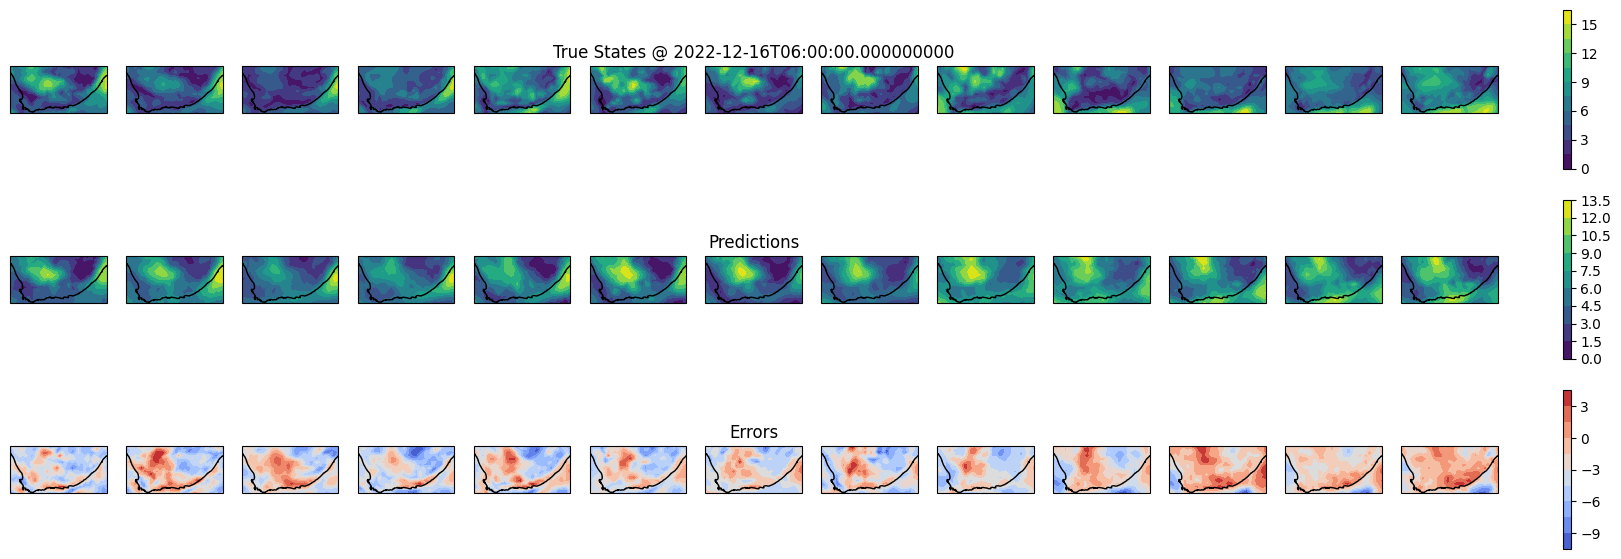

In [10]:
model_class.prediction_plots(seed=seed)